# Mark II

In [17]:
!pip install parmap

In [1]:
import pandas as pd
import numpy as np
import os 
from Bio import SeqIO
import csv
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import re

from multiprocessing import Pool

num_partitions = 18 #number of partitions to split dataframe
num_cores = 20 #number of cores on your machine


In [2]:
def lengthDistribution(df,title):
    fig = plt.figure()
    ax = fig.gca()
    pd.Series(df['length']).hist(color='blue', bins=200, ax=ax)
    plt.ylabel('Num of Seq with this length ')
    plt.xlabel('Length of Seq')
    plt.title(title)

def plotCharDistribution(dict_counts, char_totalsize, title):
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(111)
    # The bar chart, with letters along the horizontal axis and the calculated
    # letter frequencies as percentages as the bar height
    x = range(len(dict_counts))
    letters =  dict_counts.keys()
    ax.bar(x, [val / char_totalsize * 100 for key,val in dict_counts.items()], width=0.8,
        color='g', alpha=0.5, align='center')
    ax.set_xticks(x)
    ax.set_xticklabels(letters)
    ax.tick_params(axis='x', direction='out')
    ax.set_xlim(-0.5, 25.5)
    ax.yaxis.grid(True)
    ax.set_ylabel('Letter frequency, %')

def countProtien(df, title):
    # count Sequence 
    records = df['Sequence']
    print("Count Records:", len(records))
    # countAminoAcids
    counts = Counter()
    for index, row in df.iterrows():
        line= row['Sequence']
        counts.update(line.rstrip())
        total = float(sum(counts.values()))
    sorted_dict = {key: value for key, value in sorted(counts.items())}
    for key,val in sorted_dict.items():
        print("{}: {}, ({:.2%})".format(key,val, val / total))

    plotCharDistribution(sorted_dict, total, title)

## Create Bad list

In [4]:
# construct badlist
amp_uniref_df = pd.read_csv('/mnt/vdb/thesis/uniref50/badlist.ready.nr', sep='\t', header=0)
amp_uniref_df

,ID_Query,ID_Target,sequence_identity,alignment_length,number_of_mismatches,number_of_gap_openings,start-position_in_query,end-position_in_query,start-position_in_target,end-position_in_target,E-value,bit_score
0,UPI0004FCCC5E,UniRef50_K7EXB5,0.984,129,2,0,1,129,1,129,6.466000e-73,246
1,UPI0004FCCC5E,UniRef50_A0A093G9N1,0.961,129,5,0,1,129,1,129,5.383000e-71,241
2,UPI0004FCCC5E,UniRef50_Q16777,0.953,129,6,0,1,129,1,129,1.012000e-70,240
3,UPI0004FCCC5E,UniRef50_Q8IUE6,0.984,125,2,0,1,125,1,125,1.389000e-70,240
4,UPI0004FCCC5E,UniRef50_L7MTL8,0.945,129,7,0,1,129,1,129,2.612000e-70,239
...,...,...,...,...,...,...,...,...,...,...,...,...
7175653,MGYP001013544865,UniRef50_D8LWM1,0.630,100,36,0,22,118,15,114,5.172000e-30,123
7175654,MGYP001013544865,UniRef50_A0A6P7YQR2,0.592,108,44,0,11,118,13,120,3.445000e-29,120
7175655,MGYP001013544865,UniRef50_A0A433DDU2,0.608,118,45,0,4,118,6,123,4.726000e-29,120
7175656,MGYP001013544865,UniRef50_A0A1I8AJC7,0.533,120,55,0,1,119,1,120,3.944000e-27,114


In [5]:
bad_list = list(set(amp_uniref_df[amp_uniref_df['sequence_identity'] >=0.3]['ID_Target'].tolist())) 
len(bad_list)

125698

In [ ]:
bad_list

In [20]:
with open('/mnt/vdb/thesis/uniref50/badlist.sim30.uniq.txt', 'w') as f:
    for item in bad_list:
        f.write("%s\n" % item)

In [23]:
if "UniRef50_B4IPI1" in bad_list:
    print("True")

True


## Begin non-AMP Search

In [9]:
amp_fasta= '/mnt/vdb/thesis/trainingset2/set9/final_AMP_set_9.clustres_rep_seq.fasta'

nonAMPs_csv = "/mnt/vdb/thesis/trainingset2/set9/nonAMP/non_AMPs_recal_nr.V3.csv"
uniref50= "/mnt/vdb/thesis/uniref50/uniref50.excludedBadList.len2400.fasta"

In [4]:
with open(amp_fasta) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequence.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))

AMPs_df = pd.DataFrame(list(zip(identifiers, sequence, lengths)), columns =['ID', 'Sequence', 'length']) 
AMPs_df # 127018
# 113354 recal nr

,ID,Sequence,length
0,ADAM_1261|adam,FLPLIGKILGTILGK,15
1,ADAM_1262|adam,FLPLIGKVLSGIL,13
2,ADAM_1265|adam,FLPLILRKIVTAL,13
3,ADAM_6879|adam,FLPLKKLRFGLL,12
4,ADAM_1266|adam,FLPLLAASFACTVTKKC,17
...,...,...,...
35376,UPI000442611B,MQFTKLATVLIVSLMGSAAIAAPSVDNAPAVAAEEVAAAPAENLEK...,85
35377,UPI000009D32D,MEGARASSLLLLLLLGALVVYDVESKICCRAPAGKKCYNLCTALLS...,115
35378,UPI0002121F5C,MVKINKVVVASLAVAGLFLCGQNVYASRAQGTDLSRYQGYTVVKGQ...,422
35379,UPI0001C67AF3,GVPCKCGSKKGVYWFGQITGCPGGHGYKGSCNYLLGK,37


In [5]:
AMPs_df.length.describe()

count    35381.000000
mean        41.250021
std         77.932261
min          5.000000
25%         12.000000
50%         20.000000
75%         39.000000
max       2337.000000
Name: length, dtype: float64

In [6]:
df_count=AMPs_df.groupby('length').length.count().reset_index(name='count').sort_values(['count'], ascending=False)
#df_count.to_csv('df_count.csv', index=False)
_tmp_df_count =df_count
_tmp_df_count

,length,count
15,20,4939
4,9,2813
7,12,2116
8,13,1477
10,15,1192
...,...,...
410,461,1
411,462,1
412,464,1
415,468,1


In [13]:
any(ele in "MKKKILAGALVALFLLPINVFAAKGDQGVDWAIYQGDQGRFGYAHD" for ele in amp_list) 

False

In [12]:
amp_list = AMPs_df.Sequence.to_list()

In [13]:
# shuffle ID
_tmp_df_count = _tmp_df_count.sample(frac=1).reset_index(drop=True)
_tmp_df_count["count"].values

array([ 2,  2,  9, ..., 17, 18,  1])

In [8]:
num_partitions = 24 #number of partitions to split dataframe 22
num_cores = 24 #number of cores on your machine 22

In [7]:
PROTIEN_CODE = "ACDEFGHIKLMNPQRSTVWXY"
regexp  = re.compile("B|Z|J|U|O|X")

In [10]:
from os import getpid

def find_amp(_tmp_df_count):
    process_id =str(getpid())
    nonAMPs_csv = "/mnt/vdb/thesis/trainingset2/set9/nonAMP/non_amp."+process_id+".csv"
    NonAMPs_csv = open(nonAMPs_csv, 'w')
    NonAMPs_csv.write('"ID","Sequence","length"'+ '\n')
    print(process_id+" Start")
    record = SeqIO.parse(uniref50, "fasta")
    for seq_record in record:

        if regexp.search(str(seq_record.seq)):  # if contain any non coding , then ignore
            continue
            
        #if str(seq_record.seq) in amp_list: # if duplicate in amp_list, then  ignore
        #    continue
        
        seqLen = len(str(seq_record.seq))
        # update value
        _tmp_row = _tmp_df_count.loc[ _tmp_df_count['length'] == seqLen]
        if not _tmp_row.empty and  _tmp_row['count'].values > 0:
           # print (str(_tmp_row['length']) +" "+ str(_tmp_row['count']))
           # print('"'+str(seq_record.id)+'","'+str(seq_record.seq)+'","'+ str(seqLen)+'"')
            NonAMPs_csv.write('"'+str(seq_record.id)+'","'+str(seq_record.seq)+'","'+ str(seqLen)+'"' + '\n')
            
            _tmp_df_count.at[ _tmp_row.index,'count']= _tmp_row['count'] - 1
        #elif : # shulff seqeunce and subseq
                    
        else:
            if _tmp_df_count['count'].values.sum() == 0:
                print(process_id+" stop: found every range")
                break
    NonAMPs_csv.close()


from functools import partial

def parallelize_dataframe(df, func):
    _tmp_df_split = np.array_split(df, num_partitions)
        
    pool = Pool(num_cores)
    pool.map(func, _tmp_df_split)

    pool.close()
    pool.join()


In [11]:
parallelize_dataframe(_tmp_df_count, find_amp)

19670 Start19667 Start19668 Start19669 Start19671 Start
19676 Start
19679 Start
19677 Start
19687 Start19678 Start

19680 Start19685 Start19684 Start
19681 Start
19683 Start
19682 Start




19690 Start19686 Start


19689 Start
19674 Start19675 Start19673 Start
19672 Start19688 Start




19686 stop: found every range
19687 stop: found every range
19684 stop: found every range
19688 stop: found every range
19690 stop: found every range
19680 stop: found every range
19682 stop: found every range
19685 stop: found every range
19683 stop: found every range
19679 stop: found every range
19689 stop: found every range
19678 stop: found every range
19676 stop: found every range
19677 stop: found every range
19681 stop: found every range
19674 stop: found every range
19675 stop: found every range
19673 stop: found every range
19672 stop: found every range
19671 stop: found every range
19670 stop: found every range
19669 stop: found every range
19668 stop: found every range


## Merge non-AMPs and Check 

In [58]:
import glob

path = r'/mnt/vdb/thesis/trainingset2/set9/nonAMP/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

nonAMP_df = pd.concat(li, axis=0, ignore_index=True)
nonAMP_df = nonAMP_df[ ~nonAMP_df['Sequence'].isin(AMPs_df['Sequence'])]
nonAMP_df.drop_duplicates(subset=['Sequence'],inplace=True)
nonAMP_df

,ID,Sequence,length
0,UniRef50_A0A1Y1KM47,KIKDIHKELTDLEKLDTEFEELKKEQPEKVDDEYRYEKKPRKPSEK...,460
1,UniRef50_UPI001111D66B,PNAGFSGQETFNYSISDGQGGSSTATGTINVSAAPNTPPVASDDTY...,431
2,UniRef50_A0A3M2XQN1,NLEYLGRNDDQIKIRGFRVELGEIEARLAEHPEVREAVVLCRQDVP...,433
3,UniRef50_N6UDA4,MTEPGLEFKSRYEVQEELGKGRFGVVHKVVDKSTNQKLAAKFIRCR...,452
4,UniRef50_W4YVG2,MALLHTVLSHRRLFYQLGFNKDYSWGVSDLKAMMSCLNWCNKGESP...,464
...,...,...,...
29351,UniRef50_A0A396HHS3,MGLDKGLTVGVKRVQSTDDGLLVMCFDAETCPLSKAEEHLNYCRGC...,96
29352,UniRef50_K2ANW2,MDINMPLMNGIAAMNEIRKIENGSGARTPIIAFTTFNSHEEIESYL...,96
29353,UniRef50_A0A5K0W9W8,GESCLSRVKVPGSTWLEVGYSTPYEFGCFYGEQRRNCGGSFVIEDN...,96
29354,UniRef50_A0A059DHJ2,MQPSEMLCRQRELKRVVRPSHMYLKEVEFYNYYGRPCDHELVNYLV...,96


,ID,Sequence,length
9822,nonAMP9822,MEVKLWNDKREREMYENFAELYAIIKATEKLEKAYIRDLISPSEYE...,209
115964,nonAMP115964,MAKTALKVKAARKPKFAVRGYTRCQRCGRPKAVYRKFGLCRICLRE...,61
29012,nonAMP29012,MINVNEFKPGITFEDEGNIYVVLTAQHSKQGRGQANVKAKVKNLRT...,187
53614,nonAMP53614,MAGAGPTMLLREENGCCSRRQSSSSAGDSDGEREDSAAERARQQLE...,125
106574,nonAMP106574,MRHYEIVFMVHPDQSEQVPGMIERYTGAITEANGKIHRLEDWGRRQ...,131
...,...,...,...
126572,nonAMP126572,MGQKTHPLGFRIGITRDHKSSWFSNMKSYPKLAQEDYKIRSCIEKQ...,217
6971,nonAMP6971,METLTAISRWLAKQHVVTWCVQHEGELWCANAFYLFDAQKVAFYVL...,146
34008,nonAMP34008,MVGGDRRFKVSKLMAYILRHSPWEFGLEPDEEGFVELADLIRAIKT...,183
22933,nonAMP22933,MNNEQKVEALLFVAGAEGISVEELSNFTGYAKPAILTMLDNLEKNY...,196


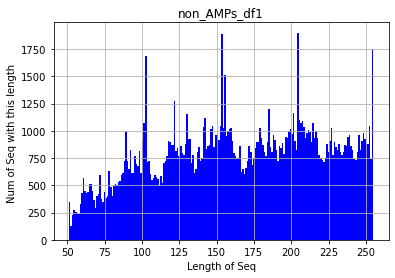

In [62]:
## add more remaining non ampset 
with open("../datasets/negativesets/M_model_train_nonAMP_sequence.numbered.fasta") as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequence.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))

non_AMPs_df1 = pd.DataFrame(list(zip(identifiers, sequence, lengths)), columns =['ID', 'Sequence', 'length']) 
non_AMPs_df1 = non_AMPs_df1[ ~non_AMPs_df1['Sequence'].isin(AMPs_df['Sequence'])]
non_AMPs_df1 = non_AMPs_df1[non_AMPs_df1['length'] >50]
lengthDistribution(non_AMPs_df1,"non_AMPs_df1")

non_AMPs_df1 = non_AMPs_df1.sample(n=6255, random_state=42)
non_AMPs_df1



,ID,Sequence,length
0,UniRef50_A0A1Y1KM47,KIKDIHKELTDLEKLDTEFEELKKEQPEKVDDEYRYEKKPRKPSEK...,460
1,UniRef50_UPI001111D66B,PNAGFSGQETFNYSISDGQGGSSTATGTINVSAAPNTPPVASDDTY...,431
2,UniRef50_A0A3M2XQN1,NLEYLGRNDDQIKIRGFRVELGEIEARLAEHPEVREAVVLCRQDVP...,433
3,UniRef50_N6UDA4,MTEPGLEFKSRYEVQEELGKGRFGVVHKVVDKSTNQKLAAKFIRCR...,452
4,UniRef50_W4YVG2,MALLHTVLSHRRLFYQLGFNKDYSWGVSDLKAMMSCLNWCNKGESP...,464
...,...,...,...
35378,nonAMP126572,MGQKTHPLGFRIGITRDHKSSWFSNMKSYPKLAQEDYKIRSCIEKQ...,217
35379,nonAMP6971,METLTAISRWLAKQHVVTWCVQHEGELWCANAFYLFDAQKVAFYVL...,146
35380,nonAMP34008,MVGGDRRFKVSKLMAYILRHSPWEFGLEPDEEGFVELADLIRAIKT...,183
35381,nonAMP22933,MNNEQKVEALLFVAGAEGISVEELSNFTGYAKPAILTMLDNLEKNY...,196


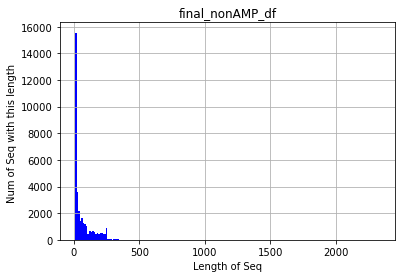

In [63]:
final_nonAMP_df =  pd.concat([nonAMP_df, non_AMPs_df1], ignore_index=True)
final_nonAMP_df.drop_duplicates(subset=['Sequence'],inplace=True, ignore_index=True)
lengthDistribution(final_nonAMP_df,"final_nonAMP_df")
final_nonAMP_df

In [64]:
final_nonAMP_df.length.describe()

count    35383.000000
mean        68.764039
std         91.232703
min         11.000000
25%         19.000000
50%         29.000000
75%         89.000000
max       2337.000000
Name: length, dtype: float64

Count Records: 35383
A: 196329, (8.07%)
C: 41340, (1.70%)
D: 127337, (5.23%)
E: 155624, (6.40%)
F: 90888, (3.74%)
G: 168128, (6.91%)
H: 54620, (2.24%)
I: 137287, (5.64%)
K: 148625, (6.11%)
L: 226622, (9.31%)
M: 72679, (2.99%)
N: 99459, (4.09%)
P: 110596, (4.55%)
Q: 94271, (3.87%)
R: 142001, (5.84%)
S: 170460, (7.01%)
T: 134888, (5.54%)
V: 165409, (6.80%)
W: 27720, (1.14%)
Y: 68795, (2.83%)


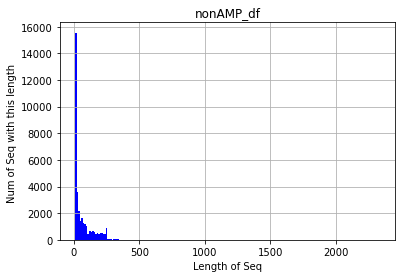

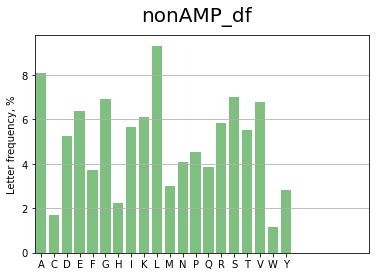

In [66]:
lengthDistribution(final_nonAMP_df,"nonAMP_df")
countProtien(final_nonAMP_df,"nonAMP_df")

In [67]:
### non AMP to FASTA (optional)

with open("/mnt/vdb/thesis/trainingset2/set9/final_nonAMP_set9.fasta", 'w') as file:
    for index, row in final_nonAMP_df.iterrows():
        header = row['ID']
        seq = row['Sequence']
        # print(header)
        file.write('>'+ header + '\n')
        file.write(seq + '\n')
           
print("--- End of Writing ----")

--- End of Writing ----


## Wirte to file

# Trainingset2

In [68]:
final_nonAMP_df['class']=1
AMPs_df['class']=0
ready_df = pd.concat([AMPs_df,final_nonAMP_df], axis=0)
# ready_df.drop_duplicates(subset=['Sequence'],inplace=True,ignore_index=True)
ready_df

,ID,Sequence,length,class
0,ADAM_1261|adam,FLPLIGKILGTILGK,15,0
1,ADAM_1262|adam,FLPLIGKVLSGIL,13,0
2,ADAM_1265|adam,FLPLILRKIVTAL,13,0
3,ADAM_6879|adam,FLPLKKLRFGLL,12,0
4,ADAM_1266|adam,FLPLLAASFACTVTKKC,17,0
...,...,...,...,...
35378,nonAMP126572,MGQKTHPLGFRIGITRDHKSSWFSNMKSYPKLAQEDYKIRSCIEKQ...,217,1
35379,nonAMP6971,METLTAISRWLAKQHVVTWCVQHEGELWCANAFYLFDAQKVAFYVL...,146,1
35380,nonAMP34008,MVGGDRRFKVSKLMAYILRHSPWEFGLEPDEEGFVELADLIRAIKT...,183,1
35381,nonAMP22933,MNNEQKVEALLFVAGAEGISVEELSNFTGYAKPAILTMLDNLEKNY...,196,1


In [69]:
ready_df[ready_df.duplicated(subset=['Sequence'])]

,ID,Sequence,length,class


In [70]:
ready_df.to_csv("/mnt/vdb/thesis/trainingset2/set9/AMP_NonAMPs.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

# trainingset1

In [24]:
nonAMP_df['class']=1
AMPs_df['class']=0

In [25]:
ready_df = pd.concat([AMPs_df,nonAMP_df], axis=0)
ready_df

,ID,Sequence,length,class
0,UPI0006248D48,MTQNVKMGYIRFVVVGMIPWDGQTRTGARAARGQGQGGILKLGAYS...,138,0
1,UPI000195AE9F,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,460,0
2,UPI000195AE9E,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,539,0
3,UPI00085D47CF,PLIYLRLLRGQFAGGLRCMCIKWWSGKHPK,30,0
4,UPI00085E5E6F,ARKKAAKAARKKAAKAGGLRCMCIKWWSGKHPK,33,0
...,...,...,...,...
68864,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
68865,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
68866,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
68867,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


In [26]:
ready_df.drop_duplicates(subset=['Sequence'],inplace=True,ignore_index=True)
print(len(ready_df[ready_df["class"] == 0]))
print(len(ready_df[ready_df["class"] == 1]))
ready_df

68869
68601


,ID,Sequence,length,class
0,UPI0006248D48,MTQNVKMGYIRFVVVGMIPWDGQTRTGARAARGQGQGGILKLGAYS...,138,0
1,UPI000195AE9F,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,460,0
2,UPI000195AE9E,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,539,0
3,UPI00085D47CF,PLIYLRLLRGQFAGGLRCMCIKWWSGKHPK,30,0
4,UPI00085E5E6F,ARKKAAKAARKKAAKAGGLRCMCIKWWSGKHPK,33,0
...,...,...,...,...
68864,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
68865,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
68866,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
68867,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


In [27]:
ready_df.to_csv("/mnt/vdb/thesis/AMP_NonAMPs.V5_C08_sim60.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

In [ ]:
ready_df.to_csv("../datasets/thesis/AMP_NonAMPs.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

# Recalibrate between two set   (Start on dataset V3. recal)

In [20]:
# remove ambigous 
NON_CODE = "B|Z|J|U|O|X"
nonAMP_df = nonAMP_df[~nonAMP_df["Sequence"].str.contains(NON_CODE, regex=True)]
nonAMP_df

,ID,Sequence,length
0,UniRef50_A7RGL2,EESEDEDKDVVLKSDAITKYYTIKDELGKGRFGVVCKCVNKKTGKQ...,311
1,UniRef50_S4NVH8,PSNPPVFTKKMQPCRVFEHEQARFEVEFDGDPLPTIKWYRENFPIK...,75
2,UniRef50_A0A0S7JAH0,MQLSGGNPRLNQLCARWQQVWLLALDRQRKLNDALDRQEELKEFAN...,282
3,UniRef50_A0A1V3ZYL8,HAGIDPTTLHGTDTAVFTGVMAQEYGPRLYEPSQGTDGYLLTGNTS...,374
4,UniRef50_F6V062,MVDTPEMVRARENQSFLSQVNYKSDVESMKGRNHSTILDTPELRQV...,374
...,...,...,...
127013,UniRef50_U4KZ92,MHLEFNRARAEYQSTPCATKPFLWL,25
127014,UniRef50_F6KAZ0,MQFFIFVSILCLFLENVGAFYMYSS,25
127015,UniRef50_A0A2S4WHR4,MGNMFLIRPMEASHSSASGVPSLCG,25
127016,UniRef50_A0A0G4NLI8,HHALAPLPRNRHHVARRPRRRRPPR,25


In [21]:
AMPs_df = AMPs_df[~AMPs_df["Sequence"].str.contains(NON_CODE, regex=True)]
AMPs_df

,ID,Sequence,length
0,EN92515250|C|B3FJD7|phage,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337
1,EN54061055|C|F8SJ56|phage,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319
2,EN4815120|C|Q8SCY1|phage,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564
...,...,...,...
127013,MGYP001502946729,MKVMASVKKICRNCKVIKRRGVVRVICTDPRHKQRQG,37
127014,MGYP001502959890,MAHKKGASSSRNGRDSNAKRLGVKRFGGQLVNAGEILVRQRGTHFH...,84
127015,MGYP001502962667,MELVELLFRAEKRLSGLHPLVADKARALIRKAYEEGIYIIITQGFR...,156
127016,MGYP000753212479,MPRSLKKGPFVDHHLLSKVLSAVEANLKKPIKTWSRRSMIIPDMIG...,91


### remove residual similarities 
```bash
# mmseqs with high sensitivites
mmseqs easy-search  /mnt/vdb/thesis/non_amp/NonAMPs.final.ready.fasta /mnt/vdb/thesis/amp_final/ampV3.ready.fasta  data.mmseq.nr tmp 

#
echo -e "ID_Query\tID_Target\tsequence_identity\talignment_length\tnumber_of_mismatches\tnumber_of_gap_openings\tstart-position_in_query\tend-position_in_query\tstart-position_in_target\tend-position_in_target\tE-value\tbit_score" | cat - data.mmseq.nr > data.ready.mmseq.nr
#
awk '{ if ($3 >= 0.3) { print $1 " " $2 } }' data.ready.mmseq.nr > sim30.txt

# result
# data.mmseq.nr  data.ready.mmseq.nr  sim30.txt  sim80.txt  sim_less30.txt
```

In [41]:
res_list_df =  pd.read_csv("/mnt/vdb/thesis/tmp/sim40.txt",names=["Non","AMP"],sep=' ')
res_list_df

,Non,AMP
0,UniRef50_P18144,UPI0002446C60
1,UniRef50_P85982,9407_dbaasp|dbaasp_peptides
2,UniRef50_P85982,ADAM_3392|adam_test
3,UniRef50_P82044,ADAM_2838|adam_test
4,UniRef50_S4R4W8,ADAM_6552|adam_test
...,...,...
680,UniRef50_A0A453GS38,jgi|Entbi1|2846|EBI_27429m.01
681,UniRef50_A0A453GS38,MGYP001449397023
682,UniRef50_A0A453GS38,MGYP001339683627
683,UniRef50_A0A453GS38,jgi|Encro1|552|EROM_020660m.01


In [44]:
res_list =res_list_df.Non.unique().tolist()

In [62]:
len(res_list)

220

In [45]:
nonAMP_df = nonAMP_df[~nonAMP_df['ID'].isin(res_list)]
nonAMP_df

,ID,Sequence,length,class
0,UniRef50_A0A2P2FG32,MFESGDGPVKLPAELQQFFKVIAGMEWPEGNVRSMRALSQAWADMV...,645,1
1,UniRef50_A0A0A1XSY1,MNELGSDAAAASVAVEGPPDSPSGKPSISQGPDRIAVAWCGPPYDG...,481,1
2,UniRef50_I2CRX4,MQISRRNAGEDSLPASHTCFFSIELPPYQSEAAMRKGLLTAITYGA...,52,1
3,UniRef50_H2XS29,MFGSSQGRRKDVKAVTVVVTDGKSWDKVEEPALLLRNKSSVIALGI...,175,1
4,UniRef50_A0A0W1A4K2,DDAFATNEDTAVTLDVNANDTFENAGHTITAINGTAIAVGGSVAVA...,148,1
...,...,...,...,...
68864,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
68865,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
68866,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
68867,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


## Labeling 

In [46]:
# setup
nonAMP_df['class']=1
AMPs_df['class']=0

/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
nonAMP_df.drop_duplicates(subset=['Sequence'],inplace=True)
nonAMP_df

/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,Sequence,length,class
0,UniRef50_A0A2P2FG32,MFESGDGPVKLPAELQQFFKVIAGMEWPEGNVRSMRALSQAWADMV...,645,1
1,UniRef50_A0A0A1XSY1,MNELGSDAAAASVAVEGPPDSPSGKPSISQGPDRIAVAWCGPPYDG...,481,1
2,UniRef50_I2CRX4,MQISRRNAGEDSLPASHTCFFSIELPPYQSEAAMRKGLLTAITYGA...,52,1
3,UniRef50_H2XS29,MFGSSQGRRKDVKAVTVVVTDGKSWDKVEEPALLLRNKSSVIALGI...,175,1
4,UniRef50_A0A0W1A4K2,DDAFATNEDTAVTLDVNANDTFENAGHTITAINGTAIAVGGSVAVA...,148,1
...,...,...,...,...
68864,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
68865,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
68866,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
68867,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


In [51]:
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,Sequence,length,class
0,UPI0006248D48,MTQNVKMGYIRFVVVGMIPWDGQTRTGARAARGQGQGGILKLGAYS...,138,0
1,UPI000195AE9F,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,460,0
2,UPI000195AE9E,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,539,0
3,UPI00085D47CF,PLIYLRLLRGQFAGGLRCMCIKWWSGKHPK,30,0
4,UPI00085E5E6F,ARKKAAKAARKKAAKAGGLRCMCIKWWSGKHPK,33,0
...,...,...,...,...
68864,UPI0005499685,NRREVSFPFGKAKFPAFRKVRSLVCCKHVNLKAKSLRETKQNIDGF...,153,0
68865,UPI00025DEBF7,MALEPLFITAGRISFFRFSAEIPNTECPGVHLHTWRSVFGILIYPC...,155,0
68866,UPI0005225A79,MVSPSQHVGPAVQARRLLGRQRNCGALEGRPEDQGFSHAGSSPAVP...,181,0
68867,UPI00081662B8,MFPGGVAPGLPRDSERGGPAGRPWIQGGDEDKESPGPPADTSDSTT...,185,0


In [52]:
ready_df = pd.concat([AMPs_df,nonAMP_df], axis=0,ignore_index=True)
ready_df

,ID,Sequence,length,class
0,UPI0006248D48,MTQNVKMGYIRFVVVGMIPWDGQTRTGARAARGQGQGGILKLGAYS...,138,0
1,UPI000195AE9F,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,460,0
2,UPI000195AE9E,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,539,0
3,UPI00085D47CF,PLIYLRLLRGQFAGGLRCMCIKWWSGKHPK,30,0
4,UPI00085E5E6F,ARKKAAKAARKKAAKAGGLRCMCIKWWSGKHPK,33,0
...,...,...,...,...
137513,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
137514,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
137515,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
137516,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


In [53]:
ready_df["Sequence"] = ready_df["Sequence"].astype(str)
dup_def = ready_df[ready_df.duplicated(subset=['Sequence'])]

In [54]:
dup_def

,ID,Sequence,length,class
72199,UniRef50_P83988,GVGYKVVVTTTAAADDDDVV,20,1
74938,UniRef50_P67932,RPKPQQFFGLM,11,1
74963,UniRef50_B3EWE8,LMCTHPLDCSN,11,1
74964,UniRef50_P86706,TESYFVFSVGM,11,1
74965,UniRef50_B3EWC5,LYKLVKVVLNM,11,1
...,...,...,...,...
133512,UniRef50_P82884,FLPFLATLLSKVL,13,1
133514,UniRef50_P0C8U2,FFGSVLKLIPKIL,13,1
133516,UniRef50_P56921,FLPLIGKVLSGIL,13,1
133517,UniRef50_P84858,FLPLLFGAISHLL,13,1


In [55]:
ready_df.drop_duplicates(subset=['Sequence'],inplace=True)
ready_df

,ID,Sequence,length,class
0,UPI0006248D48,MTQNVKMGYIRFVVVGMIPWDGQTRTGARAARGQGQGGILKLGAYS...,138,0
1,UPI000195AE9F,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,460,0
2,UPI000195AE9E,MAEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHY...,539,0
3,UPI00085D47CF,PLIYLRLLRGQFAGGLRCMCIKWWSGKHPK,30,0
4,UPI00085E5E6F,ARKKAAKAARKKAAKAGGLRCMCIKWWSGKHPK,33,0
...,...,...,...,...
137513,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36,1
137514,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36,1
137515,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36,1
137516,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36,1


In [65]:
with open("/mnt/vdb/thesis/non_amp/NonampV5_C08_sim60.ready.fasta", 'w') as file:
    for index, row in ready_df[ready_df["class"] == 1].iterrows():
        header = row['ID']
        seq = row['Sequence']
        # print(header)
        file.write('>'+ header + '\n')
        file.write(seq + '\n')
           
print("--- End of Writing ----")

--- End of Writing ----


In [56]:
print(len(ready_df[ready_df["class"] == 0]))
print(len(ready_df[ready_df["class"] == 1]))

68869
68520


In [77]:
suppop = ready_df["ID"][ready_df["class"] == 1].sample(n=8533, random_state=42)
new_ready_df = ready_df[~ready_df['ID'].isin(suppop)]

In [79]:
print(len(new_ready_df[new_ready_df["class"] == 0]))
print(len(new_ready_df[new_ready_df["class"] == 1]))

116760
116760


In [58]:
# T test 
#A large t-score tells you that the groups are different.
#A small t-score tells you that the groups are similar.

# t-statistic is greater than the critical t-value
# the test concludes that there is a statistically significant difference between 
# the two populations. Therefore, you reject the null hypothesis 
# that there is no statistically significant difference between the two populations.

# If there is no statistically significant difference between the two populations.
# The test fails to reject the null hypothesis and we accept the alternate hypothesis

# nuLL
# h

## Import the packages
import numpy as np
from scipy import stats


## Define 2 random distributions
#Sample Size


a = ready_df[ready_df["class"] == 0]
b = ready_df[ready_df["class"] == 1]

### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a["length"],b["length"])
print("t = " + str(t2))
print("p = " + str(p2))

t = -0.6003099051363778
p = 0.5483007088502838


In [59]:
from collections import namedtuple

import numpy as np
import scipy.stats as st

TtestResults = namedtuple("Ttest", "T p")
def t_welch(x, y, tails=2):
    """
    Welch's t-test for two unequal-size samples, not assuming equal variances
    """
    assert tails in (1,2), "invalid: tails must be 1 or 2, found %s"%str(tails)
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = x.size, y.size
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    df = ((vx/nx + vy/ny)**2 / # Welch-Satterthwaite equation
            ((vx/nx)**2 / (nx - 1) + (vy/ny)**2 / (ny - 1)))
    t_obs = (x.mean() - y.mean()) / np.sqrt(vx/nx + vy/ny)
    p_value = tails * st.t.sf(abs(t_obs), df)
    return TtestResults(t_obs, p_value)

t_welch(a["length"],b["length"])

Ttest(T=-0.6003080248973535, p=0.548301961737596)

In [60]:
ready_df.to_csv("/mnt/vdb/thesis/AMP_NonAMPs.V5_C08_sim60.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

In [21]:
ready_df.to_csv("../datasets/thesis/AMP_NonAMPs.ready.csv",sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL)

# Check sim

mmseqs easy-search  /mnt/vdb/thesis/non_amp/NonampV5_C08_sim60.ready.fasta /mnt/vdb/thesis/amp_final/ampV5_C08_sim60.ready.fasta --start-sens 8.5 -s 8.5 -c 0.8 check_sims/data.mmseq.nr check_sims/tmp

/mnt/vdb/thesis/non_amp/NonampV5_C08_sim60.ready.fasta

awk '{ if ($3 >= 0.8) { print $1 " " $2 } }' data.mmseq.nr > sim80.txt